# **TCN 모델을 이용한 환율 예측**
- feature : 분석한 전체 변수
- 선택법
  - LASSO
  - Feature Importance (RF기반)
  - Permutation Importance (순열 중요도)

In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf
import os

def set_seed(seed=30):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/LikeLion/DataTone/exchange_final.csv")

df.head()

,Unnamed: 0,TIME,원/달러환율,한국 장기 시장 금리,미국 장기 시장 금리,중국 장기 시장 금리,한국 단기 시장 금리,미국 단기 시장 금리,중국 단기 시장 금리,전체 수출 총액,...,한국 중앙정부 부채 비율,미국 중앙정부 부채 비율,한국 10년 채권수익률,미국 10년 채권수익률,한국 인플레이션율,미국 인플레이션율,인플레이션 격차,실질GDP,실질GDP성장률,vix
0,0,2000-01-01,1130.32,NaN,6.66,NaN,7.28,5.95,2.72,12162425,...,NaN,33.267642,NaN,NaN,NaN,NaN,NaN,883159.302102,NaN,24.95
1,1,2000-02-01,1129.29,NaN,6.52,NaN,7.13,6.01,2.73,12676042,...,NaN,34.865592,NaN,NaN,NaN,NaN,NaN,876860.243167,NaN,23.37
2,2,2000-03-01,1115.75,NaN,6.26,NaN,7.00,6.14,2.64,14429703,...,NaN,36.463543,NaN,NaN,NaN,NaN,NaN,870598.143103,NaN,24.11
3,3,2000-04-01,1110.01,NaN,5.99,NaN,7.06,6.28,2.64,13522040,...,NaN,38.061493,NaN,NaN,NaN,NaN,NaN,864372.677584,NaN,26.20
4,4,2000-05-01,1121.37,NaN,6.44,NaN,7.14,6.71,2.57,14636755,...,NaN,39.659444,NaN,NaN,NaN,NaN,NaN,858183.526068,NaN,23.65


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     300 non-null    int64  
 1   TIME           300 non-null    object 
 2   원/달러환율         300 non-null    float64
 3   한국 장기 시장 금리    291 non-null    float64
 4   미국 장기 시장 금리    300 non-null    float64
 5   중국 장기 시장 금리    132 non-null    float64
 6   한국 단기 시장 금리    300 non-null    float64
 7   미국 단기 시장 금리    299 non-null    float64
 8   중국 단기 시장 금리    299 non-null    float64
 9   전체 수출 총액       300 non-null    int64  
 10  미국 수출 총액       300 non-null    int64  
 11  중국 수출 총액       300 non-null    int64  
 12  전체 수입 총액       300 non-null    int64  
 13  미국 수입 총액       300 non-null    int64  
 14  중국 수입 총액       300 non-null    int64  
 15  소득 교역 조건 지수    300 non-null    float64
 16  해외 직접 투자 금액    300 non-null    int64  
 17  경제 심리 지수       264 non-null    float64
 18  한국 기준 금리  

In [ ]:
m2 = pd.read_csv('/content/drive/MyDrive/LikeLion/DataTone/M2_2000_2024.CSV', encoding='cp949')

# 'Jan-00' → datetime으로 변환 (월 초 날짜 기준)
m2['TIME'] = pd.to_datetime(m2['TIME'], format='%Y-%m')

# 확인
print(m2.head())

        TIME        M2  증가율
0 2000-01-01  674.7231 -0.8
1 2000-02-01  677.6103  0.4
2 2000-03-01  685.3970  1.1
3 2000-04-01  689.5531  0.6
4 2000-05-01  688.6894 -0.1


In [ ]:
df['TIME'] = pd.to_datetime(df['TIME'])

# 병합
df_merged = pd.merge(df, m2, on='TIME', how='left')

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     300 non-null    int64         
 1   TIME           300 non-null    datetime64[ns]
 2   원/달러환율         300 non-null    float64       
 3   한국 장기 시장 금리    291 non-null    float64       
 4   미국 장기 시장 금리    300 non-null    float64       
 5   중국 장기 시장 금리    132 non-null    float64       
 6   한국 단기 시장 금리    300 non-null    float64       
 7   미국 단기 시장 금리    299 non-null    float64       
 8   중국 단기 시장 금리    299 non-null    float64       
 9   전체 수출 총액       300 non-null    int64         
 10  미국 수출 총액       300 non-null    int64         
 11  중국 수출 총액       300 non-null    int64         
 12  전체 수입 총액       300 non-null    int64         
 13  미국 수입 총액       300 non-null    int64         
 14  중국 수입 총액       300 non-null    int64         
 15  소득 교역 조건 지수    300 non-

## **전체 변수 (31개)**

In [ ]:
# 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

In [ ]:
len(features)

31

## 타겟 설정

In [ ]:
# 타겟 생성
target = df_merged['원/달러환율']

## 결측치 처리
- 선형 보간 (interpolate(method='linear'))
- 순방향/역방향 채움 (ffill, bfill)

In [ ]:
# 결측치 처리
df_filled = df_merged.interpolate(method='linear')
df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')

<ipython-input-12-8ada04c1227d>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_filled.fillna(method='ffill').fillna(method='bfill')


## train/test 분할
- 시계열 순서 유지한 80% / 20% 분할

In [ ]:
# 전체 길이 기준으로 분할 비율 설정
total_len = len(df_filled)
split = int(total_len * 0.8)

# 시계열 순서 유지하여 분할
train_df = df_filled.iloc[:split]
test_df = df_filled.iloc[split:]

## 정규화

In [ ]:
# 정규화 - 훈련 데이터로만 스케일러 학습
scaler = MinMaxScaler()

# 훈련 데이터로 스케일러 학습 및 변환
train_scaled_array = scaler.fit_transform(train_df[features + ['원/달러환율']])
train_scaled = pd.DataFrame(train_scaled_array, columns=features + ['원/달러환율'])
train_scaled['TIME'] = train_df['TIME'].values  # 시간 정보 복원

# 테스트 데이터에 학습된 스케일러 적용
test_scaled_array = scaler.transform(test_df[features + ['원/달러환율']])
test_scaled = pd.DataFrame(test_scaled_array, columns=features + ['원/달러환율'])
test_scaled['TIME'] = test_df['TIME'].values  # 시간 정보 복원

# 입력(X), 타겟(y) 분리
X_train = train_scaled[features]
X_test = test_scaled[features]

y_train = train_scaled['원/달러환율']
y_test = test_scaled['원/달러환율']

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


## **TCN 모델링**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, LayerNormalization, Activation
from tensorflow.keras.layers import SpatialDropout1D, Add, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)


# TCN 블록 구현
def tcn_block(x, dilation_rate, nb_filters, kernel_size, dropout_rate=0.1):
    # Skip 연결을 위해 입력값 저장
    prev_x = x

    # 1D dilated causal convolution
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal',
               activation=None)(x)

    # Layer Normalization & Activation & Dropout
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)

    # 두 번째 convolution
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal',
               activation=None)(x)

    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = SpatialDropout1D(dropout_rate)(x)

    # Skip 연결을 위한 1x1 conv
    if prev_x.shape[-1] != nb_filters:
        prev_x = Conv1D(nb_filters, kernel_size=1)(prev_x)

    # Skip 연결 추가
    x = Add()([x, prev_x])
    return x

In [ ]:
# TCN 모델 생성 함수
def create_tcn_model(input_shape, nb_filters=64, kernel_size=3, nb_stacks=1, dilations=None, dropout_rate=0.1):
    if dilations is None:
        dilations = [1, 2, 4, 8, 16]

    input_layer = Input(shape=input_shape)
    x = input_layer

    # 초기 convolution
    x = Conv1D(filters=nb_filters, kernel_size=1, padding='causal')(x)

    # TCN 스택
    for _ in range(nb_stacks):
        for dilation in dilations:
            x = tcn_block(x, dilation, nb_filters, kernel_size, dropout_rate)

    # 출력층
    x = GlobalAveragePooling1D()(x)
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

import keras_tuner as kt

def build_tcn_model(hp):
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    input_layer = Input(shape=input_shape)
    x = Conv1D(filters=hp.Int("filters", 16, 128, step=16),
               kernel_size=1, padding='causal')(input_layer)

    for dilation in [1, 2, 4, 8, 16]:
        x = tcn_block(
            x,
            dilation_rate=dilation,
            nb_filters=hp.Int("filters", 16, 128, step=16),
            kernel_size=hp.Choice("kernel_size", [2, 3, 4]),
            dropout_rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
        )

    x = GlobalAveragePooling1D()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model


# 시계열 데이터를 지도학습 형태로 변환하는 함수
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 데이터 준비 - 선택된 피처만 사용
X_train_selected = train_scaled[features]
X_test_selected = test_scaled[features]

# 시계열 데이터 준비 (time_steps 설정)
time_steps = 12

# 시퀀스 생성
X_train_seq, y_train_seq = create_sequences(X_train_selected.values, y_train.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_selected.values, y_test.values, time_steps)

print(f"훈련 데이터 형태: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"테스트 데이터 형태: {X_test_seq.shape}, {y_test_seq.shape}")
print(f"선택된 피처 개수: {len(features)}")
print(f"선택된 피처: {features}")

훈련 데이터 형태: (228, 12, 31), (228,)
테스트 데이터 형태: (48, 12, 31), (48,)
선택된 피처 개수: 31
선택된 피처: ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액', '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격', '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액', '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', 'M2', '실질GDP성장률', 'vix']


## **TCN 모델 생성**


In [ ]:
# TCN 모델 생성 (최적 파라미터 적용)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (time_steps, 선택된 피처 개수)
model = create_tcn_model(
    input_shape,
    nb_filters=64,
    kernel_size=2,
    nb_stacks=1,
    dilations=[1, 2, 4, 8, 16, 32],
    dropout_rate=0.1)

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

# 모델 요약
model.summary()

# 조기 종료 콜백
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# 모델 체크포인트
model_checkpoint = ModelCheckpoint(
    filepath='best_tcn_model_selected_features.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │      2,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 64)    │      8,256 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 64)    │        128 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 12, 64)    │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 12, 64)    │          0 │ activation[0][0]  │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 64)    │      8,256 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 12, 64)    │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 12, 64)    │          0 │ activation_1[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ spatial_dropout1… │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 64)    │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 64)    │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 12, 64)    │          0 │ activation_2[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 12, 64)    │      8,256 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 64)    │        128 │ conv1d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 12, 64)    │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 102,721 (401.25 KB)

 Trainable params: 102,721 (401.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tuner = kt.RandomSearch(
    build_tcn_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='tcn_tuning'
)

tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10)],
    verbose=1
)


Trial 10 Complete [00h 00m 23s]
val_loss: 0.008939404040575027

Best val_loss So Far: 0.008939404040575027
Total elapsed time: 00h 04m 32s


## **모델 학습**

In [ ]:
# 최적 하이퍼파라미터 적용한 모델로 재학습
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.3073
Epoch 1: val_loss improved from inf to 0.30095, saving model to best_tcn_model_selected_features.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - loss: 3.2711 - val_loss: 0.3009
Epoch 2/300
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2832
Epoch 2: val_loss did not improve from 0.30095
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.2127 - val_loss: 1.4840
Epoch 3/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0475
Epoch 3: val_loss did not improve from 0.30095
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9888 - val_loss: 0.3291
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4985
Epoch 4: val_loss did not improve from 0.30095
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4923 - val_loss: 0.6829
Epoch 5/300
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3900
Epoch 5: val_loss improved from 0.30095 to 0.05535, saving model to best_tcn_model_selected_features.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3661 - val_loss: 0.0554
Epoch 6/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3155
Epoch 6: val_loss did not improve from 0.05535
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3132 - val_loss: 0.2244
Epoch 7/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2787
Epoch 7: val_loss did not improve from 0.05535
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2796 - val_loss: 0.0710
Epoch 8/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2367
Epoch 8: val_loss improved from 0.05535 to 0.04654, saving model to best_tcn_model_selected_features.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2353 - val_loss: 0.0465
Epoch 9/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2382
Epoch 9: val_loss did not improve from 0.04654
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2340 - val_loss: 0.1228
Epoch 10/300
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2048
Epoch 10: val_loss did not improve from 0.04654
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2057 - val_loss: 0.0816
Epoch 11/300
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1800
Epoch 11: val_loss did not improve from 0.04654
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1776 - val_loss: 0.1508
Epoch 12/300
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1966
Epoch 12: val_loss did not improve from 0.04654
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1933 - val_loss: 0.1111
Epoch 13/300
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1724
Epoch 13: val_loss did not improve from 0.04654
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1708 - val_loss: 0.2990


## 선택법별 피처 중요도

## 선택법(1) Permutation Importance

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━

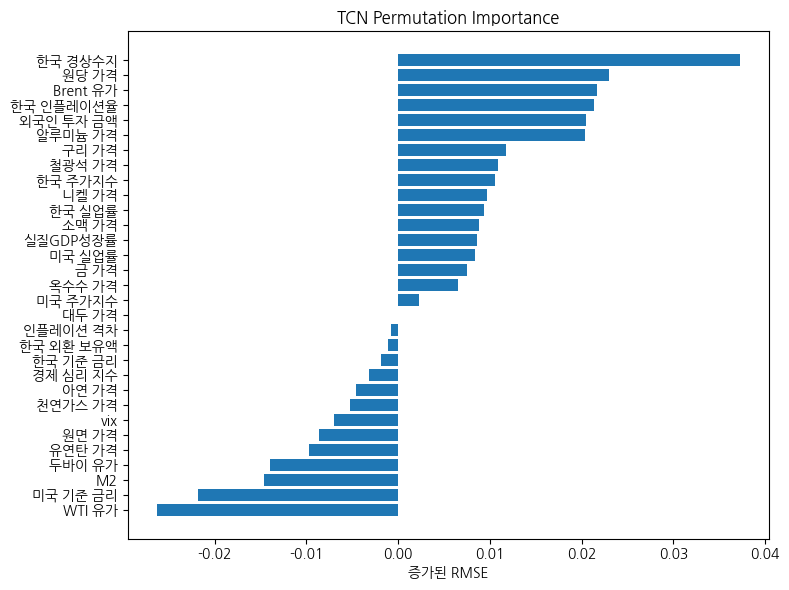

In [ ]:
# ─── 여기에 삽입: Permutation Importance ───
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def permutation_importance_tcn(model, X, y, feature_names, n_repeats=5):
    y_pred = model.predict(X).flatten()
    baseline = math.sqrt(mean_squared_error(y, y_pred))
    imps = []
    for i, name in enumerate(feature_names):
        rmses = []
        for _ in range(n_repeats):
            Xp = X.copy()
            Xp[:, :, i] = np.random.permutation(Xp[:, :, i])
            yp = model.predict(Xp).flatten()
            rmses.append(math.sqrt(mean_squared_error(y, yp)))
        imps.append((name, np.mean(rmses) - baseline))
    return sorted(imps, key=lambda x: x[1], reverse=True)

feature_names = features
importances = permutation_importance_tcn(model, X_test_seq, y_test_seq, feature_names)

names, scores = zip(*importances)
plt.figure(figsize=(8,6))
plt.barh(names[::-1], scores[::-1])
plt.xlabel('증가된 RMSE')
plt.title('TCN Permutation Importance')
plt.tight_layout()
plt.show()

top20 = [n for n,_ in importances[:20]]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014594841674353543, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017462839260449226, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001768256543376756, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent

== Lasso Top 10 ==
M2           0.397467
인플레이션 격차     0.250972
니켈 가격        0.239494
vix          0.236364
한국 외환 보유액    0.229296
WTI 유가       0.164947
아연 가격        0.141507
천연가스 가격      0.131961
알루미늄 가격      0.124049
금 가격         0.078848
dtype: float64

== RF Top 10 ==
미국 주가지수     0.399362
천연가스 가격     0.168055
알루미늄 가격     0.091428
M2          0.074974
니켈 가격       0.055308
경제 심리 지수    0.038186
아연 가격       0.035200
vix         0.031451
인플레이션 격차    0.018185
실질GDP성장률    0.015786
dtype: float64

== Permutation Top 10 ==
한국 경상수지      0.037263
원당 가격        0.022962
Brent 유가     0.021733
한국 인플레이션율    0.021336
외국인 투자 금액    0.020517
알루미늄 가격      0.020328
구리 가격        0.011804
철광석 가격       0.010917
한국 주가지수      0.010615
니켈 가격        0.009713
dtype: float64


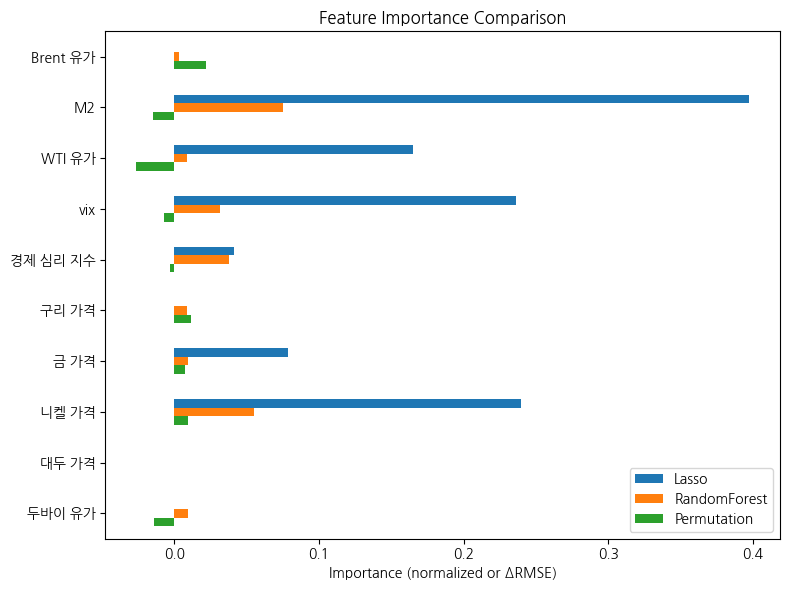

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 0) 기본 변수 리스트
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 1) LassoCV 로 변수 중요도 (절대 계수) 계산
X_train_tab = train_scaled[features].values
y_train_tab = train_scaled['원/달러환율'].values

lasso = LassoCV(cv=5, random_state=42).fit(X_train_tab, y_train_tab)
lasso_coef = pd.Series(np.abs(lasso.coef_), index=features)
lasso_rank = lasso_coef.sort_values(ascending=False)

# 2) RandomForestRegressor 로 Feature Importance 계산
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_tab, y_train_tab)
rf_imp = pd.Series(rf.feature_importances_, index=features)
rf_rank = rf_imp.sort_values(ascending=False)

# 3) Permutation Importance (TCN) — 이전에 정의한 함수 사용
#    importances = permutation_importance_tcn(model, X_test_seq, y_test_seq, features)
#    names, scores = zip(*importances)
perm_rank = pd.Series(
    data=[score for _, score in importances],
    index=[name for name, _ in importances]
).sort_values(ascending=False)

# 4) 세 가지를 한 테이블로 합치기
df_imp = pd.DataFrame({
    'Lasso': lasso_rank,
    'RandomForest': rf_rank,
    'Permutation': perm_rank
})
# NaN 은 해당 방법에서 계산되지 않은 경우 (e.g. Permutation 은 순서가 약간 다를 수 있음)
df_imp = df_imp.fillna(0)

# 5) 상위 10개 변수 각 방법별로 출력
print("== Lasso Top 10 ==")
print(lasso_rank.head(10))
print("\n== RF Top 10 ==")
print(rf_rank.head(10))
print("\n== Permutation Top 10 ==")
print(perm_rank.head(10))

# 6) 시각화: 상위 10개만 골라 막대그래프
topN = 10
df_imp.head(topN).plot.barh(figsize=(8,6))
plt.xlabel("Importance (normalized or ΔRMSE)")
plt.title("Feature Importance Comparison")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 1) Top Features 리스트 (이미 permutation importance로 정렬된 순서)
top_features = ['유연탄 가격', '한국 실업률', 'Brent 유가', 'M2', '니켈 가격', '실질GDP성장률', 'vix',
                '인플레이션 격차', '한국 외환 보유액', '금 가격', '아연 가격',
                '두바이 유가', '천연가스 가격', '구리 가격', '알루미늄 가격', '미국 주가지수',
                '경제 심리 지수', '외국인 투자 금액', '한국 인플레이션율', 'WTI 유가']
# 2) 평가용 함수 정의
def train_and_eval(feature_list, time_steps=12,
                   nb_filters=64, kernel_size=2, dilations=[1,2,4,8,16,32], dropout=0.1):
    # 2-1) 시퀀스 생성
    X_tr = train_scaled[feature_list].values
    X_te = test_scaled[feature_list].values
    y_tr = train_scaled['원/달러환율'].values
    y_te = test_scaled['원/달러환율'].values

    def make_sequences(X, y, ts):
        Xs, ys = [], []
        for i in range(len(X)-ts):
            Xs.append(X[i:i+ts])
            ys.append(y[i+ts])
        return np.array(Xs), np.array(ys)

    X_tr_seq, y_tr_seq = make_sequences(X_tr, y_tr, time_steps)
    X_te_seq, y_te_seq = make_sequences(X_te, y_te, time_steps)

    # 2-2) 모델 생성
    inp_shape = (time_steps, len(feature_list))
    model = create_tcn_model(inp_shape,
                             nb_filters=nb_filters,
                             kernel_size=kernel_size,
                             nb_stacks=1,
                             dilations=dilations,
                             dropout_rate=dropout)
    model.compile(optimizer=Adam(1e-3), loss='mse')

    # 2-3) 학습
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    cp = ModelCheckpoint('tmp.h5', monitor='val_loss', save_best_only=True, verbose=0)
    model.fit(
        X_tr_seq, y_tr_seq,
        validation_data=(X_te_seq, y_te_seq),
        epochs=100, batch_size=32,
        callbacks=[es, cp],
        verbose=0
    )

    # 2-4) 예측·평가
    pred_tr = model.predict(X_tr_seq).flatten()
    pred_te = model.predict(X_te_seq).flatten()
    def metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        return rmse, mae, r2

    tr_rmse, tr_mae, tr_r2 = metrics(y_tr_seq, pred_tr)
    te_rmse, te_mae, te_r2 = metrics(y_te_seq, pred_te)

    return {
        'N_features': len(feature_list),
        'features': feature_list,
        'train_rmse': tr_rmse, 'train_mae': tr_mae, 'train_r2': tr_r2,
        'test_rmse': te_rmse,  'test_mae': te_mae,  'test_r2': te_r2,
    }

# 3) 여러 N에 대해 반복 실행
results = []
for N in range(1,21):
    feats = top_features[:N]
    res = train_and_eval(feats, time_steps=12)
    results.append(res)

# 4) DataFrame으로 정리
df_results = pd.DataFrame(results)[[
    'N_features','test_rmse','test_mae','test_r2'
]]
print(df_results)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
    N_features  test_rmse  test_mae   test_r2
0            1   0.146452  0.121133  0.266537
1            2   0.127334  0.102768  0.445533
2            3   0.082418  0.061900  0.767710
3            4   0.343434  0.287114 -3.033435
4            5   0.158923  0.138706  0.136300
5            6   0.171346  0.148180 -0.004003
6            7   0.217804  0.188912 -0.622252
7            8   0.201460  0.170782 -0.387923
8            9   0.142556  0.124116  0.305038
9           10   0.120446  0.093581  0.503899
10          11   0.240224  0.197805 -0.973423
11          12   0.285128  0.244036 -1.780135
12          13   0.245533  0.195020 -1.061608
13          14   0.229455  0.201817 -0.800454
14          15   0.149895  0.120330  0.231641
15          16   0.187118  0.165018 -0.197347
16          17   0.204398  0.176416 -0.428693
17          18   0.173362  0.138506 -0.027766
18          19   0.147466  0.122346  0.256350
19 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) feature 리스트 + 타겟 인덱스 정의 (scaler.fit_transform 시 사용한 순서와 동일해야 합니다)
feature_names = features + ['원/달러환율']
target_idx   = feature_names.index('원/달러환율')

# 2) 역변환 함수
def inverse_transform_sequence(y_scaled, scaler, target_feature='원/달러환율'):
    feature_names = list(scaler.feature_names_in_)
    n_feats      = scaler.n_features_in_
    target_idx   = feature_names.index(target_feature)
    dummy = np.zeros((len(y_scaled), n_feats))
    dummy[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_idx]

# 3) 예시: N별 성능 비교 루프에 아래를 추가
results_orig = []

for N in range(1, 21):
    feats = top_features[:N]

    # 2-1) N개 피처로 X_train/X_test 재추출
    X_tr = train_scaled[feats].values
    X_te = test_scaled[feats].values
    y_tr = train_scaled['원/달러환율'].values
    y_te = test_scaled['원/달러환율'].values

    # 2-2) 시퀀스 생성
    X_tr_seq, y_tr_seq = create_sequences(X_tr, y_tr, time_steps=12)
    X_te_seq, y_te_seq = create_sequences(X_te, y_te, time_steps=12)

    # 2-3) 모델 정의 (input_shape=(12, N))
    inp_shape = (12, N)
    model = create_tcn_model(inp_shape,
                             nb_filters=64,
                             kernel_size=2,
                             dilations=[1,2,4,8,16,32],
                             dropout_rate=0.1)
    model.compile(optimizer=Adam(1e-3), loss='mse')

    # 2-4) 학습
    model.fit(
        X_tr_seq, y_tr_seq,
        validation_data=(X_te_seq, y_te_seq),
        epochs=100, batch_size=32,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    # 2-5) 예측 및 역변환
    pred_te = model.predict(X_te_seq).flatten()
    y_true_orig = inverse_transform_sequence(y_te_seq, scaler)
    y_pred_orig = inverse_transform_sequence(pred_te,    scaler)

    # 2-6) 성능 계산
    rmse_o = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_o  = mean_absolute_error   (y_true_orig, y_pred_orig)
    r2_o   = r2_score              (y_true_orig, y_pred_orig)

    results_orig.append({
        'N_features': N,
        'rmse_orig': rmse_o,
        'mae_orig': mae_o,
        'r2_orig': r2_o
    })

# 3) 결과 정리
df_orig = pd.DataFrame(results_orig)
print(df_orig)



Epoch 1: val_loss did not improve from 0.04654

Epoch 2: val_loss did not improve from 0.04654

Epoch 3: val_loss did not improve from 0.04654

Epoch 4: val_loss did not improve from 0.04654

Epoch 5: val_loss did not improve from 0.04654

Epoch 6: val_loss improved from 0.04654 to 0.03985, saving model to best_tcn_model_selected_features.h5



Epoch 7: val_loss improved from 0.03985 to 0.03423, saving model to best_tcn_model_selected_features.h5



Epoch 8: val_loss improved from 0.03423 to 0.02663, saving model to best_tcn_model_selected_features.h5



Epoch 9: val_loss did not improve from 0.02663

Epoch 10: val_loss did not improve from 0.02663

Epoch 11: val_loss did not improve from 0.02663

Epoch 12: val_loss did not improve from 0.02663

Epoch 13: val_loss did not improve from 0.02663

Epoch 14: val_loss did not improve from 0.02663

Epoch 15: val_loss improved from 0.02663 to 0.02501, saving model to best_tcn_model_selected_features.h5



Epoch 16: val_loss did not improve from 0.02501

Epoch 17: val_loss did not improve from 0.02501

Epoch 18: val_loss did not improve from 0.02501

Epoch 19: val_loss improved from 0.02501 to 0.02444, saving model to best_tcn_model_selected_features.h5



Epoch 20: val_loss did not improve from 0.02444

Epoch 21: val_loss did not improve from 0.02444

Epoch 22: val_loss did not improve from 0.02444

Epoch 23: val_loss did not improve from 0.02444

Epoch 24: val_loss did not improve from 0.02444

Epoch 25: val_loss did not improve from 0.02444

Epoch 26: val_loss did not improve from 0.02444

Epoch 27: val_loss did not improve from 0.02444

Epoch 28: val_loss did not improve from 0.02444

Epoch 29: val_loss did not improve from 0.02444

Epoch 30: val_loss did not improve from 0.02444

Epoch 31: val_loss did not improve from 0.02444

Epoch 32: val_loss did not improve from 0.02444

Epoch 33: val_loss did not improve from 0.02444

Epoch 34: val_loss did not improve from 0.02444

Epoch 35: val_loss did not improve from 0.02444

Epoch 36: val_loss did not improve from 0.02444

Epoch 37: val_loss did not improve from 0.02444

Epoch 38: val_loss did not improve from 0.02444

Epoch 39: val_loss did not improve from 0.02444
Epoch 39: early stop

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step

Epoch 1: val_loss did not improve from 0.02444

Epoch 2: val_loss did not improve from 0.02444

Epoch 3: val_loss did not improve from 0.02444

Epoch 4: val_loss did not improve from 0.02444

Epoch 5: val_loss did not improve from 0.02444

Epoch 6: val_loss did not improve from 0.02444

Epoch 7: val_loss did not improve from 0.02444

Epoch 8: val_loss did not improve from 0.02444

Epoch 9: val_loss did not improve from 0.02444

Epoch 10: val_loss did not improve from 0.02444

Epoch 11: val_loss did not improve from 0.02444

Epoch 12: val_loss did not improve from 0.02444

Epoch 13: val_loss did not improve from 0.02444

Epoch 14: val_loss did not improve from 0.02444

Epoch 15: val_loss did not improve from 0.02444

Epoch 16: val_loss did not improve from 0.02444

Epoch 17: val_loss did not improve from 0.02444

Epoch 18: val_loss did not improve from 0.02444

Epoch 19: val_loss did not improve from 0.02444

Epoch 20: val_loss did not improve fro


Epoch 22: val_loss improved from 0.01777 to 0.00867, saving model to best_tcn_model_selected_features.h5



Epoch 23: val_loss did not improve from 0.00867

Epoch 24: val_loss did not improve from 0.00867

Epoch 25: val_loss did not improve from 0.00867

Epoch 26: val_loss did not improve from 0.00867

Epoch 27: val_loss did not improve from 0.00867

Epoch 28: val_loss did not improve from 0.00867

Epoch 29: val_loss did not improve from 0.00867

Epoch 30: val_loss did not improve from 0.00867

Epoch 31: val_loss did not improve from 0.00867

Epoch 32: val_loss did not improve from 0.00867

Epoch 33: val_loss did not improve from 0.00867

Epoch 34: val_loss did not improve from 0.00867

Epoch 35: val_loss did not improve from 0.00867

Epoch 36: val_loss did not improve from 0.00867

Epoch 37: val_loss did not improve from 0.00867

Epoch 38: val_loss did not improve from 0.00867

Epoch 39: val_loss did not improve from 0.00867

Epoch 40: val_loss did not improve from 0.00867

Epoch 41: val_loss did not improve from 0.00867

Epoch 42: val_loss did not improve from 0.00867
Epoch 42: early stop

Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.7639
Epoch 1: val_loss did not improve from 0.00867
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - loss: 10.6891 - val_loss: 1.1708
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.8374
Epoch 2: val_loss did not improve from 0.00867
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 1.8224 - val_loss: 0.2045
Epoch 3/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.0300
Epoch 3: val_loss did not improve from 0.00867
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 1.0259 - val_loss: 0.4112
Epoch 4/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8482
Epoch 4: val_loss did not improve from 0.00867
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.8572 - val_loss: 0.1146
Epoch 5/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5887
Epoch 5: val_loss did not improve from 0.00867
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.5941 - val_loss: 0.1135
Epoch 6/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4032
Epoch 6: va

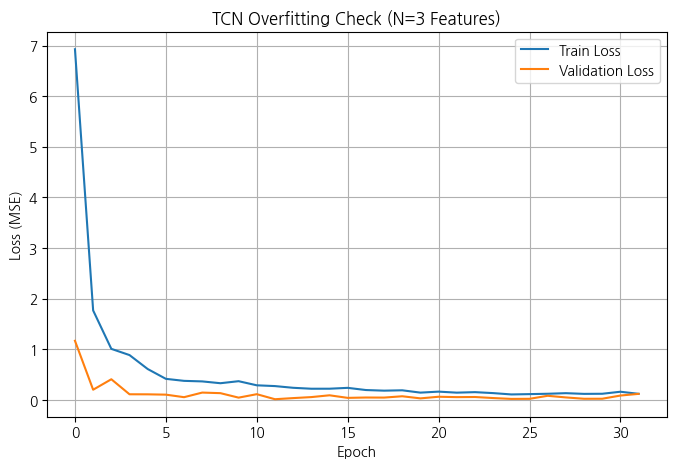

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step


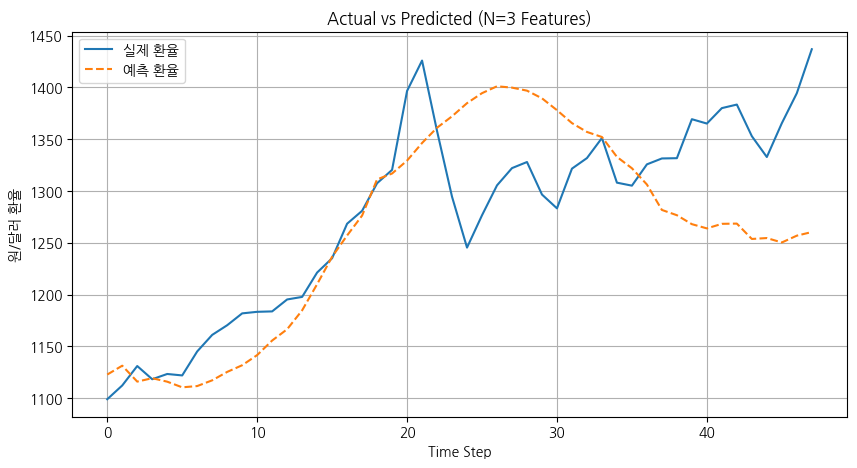

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# 1) Best 모델 재학습 (N=3)
best_N = 2
best_feats = top_features[:best_N]

# 시퀀스 재생성
X_tr = train_scaled[best_feats].values
y_tr = train_scaled['원/달러환율'].values
X_te = test_scaled[best_feats].values
y_te = test_scaled['원/달러환율'].values

X_tr_seq, y_tr_seq = create_sequences(X_tr, y_tr, time_steps=12)
X_te_seq, y_te_seq = create_sequences(X_te, y_te, time_steps=12)

# 모델 초기화 및 생성
K.clear_session()
model_best = create_tcn_model(
    input_shape=(12, best_N),
    nb_filters=64,
    kernel_size=2,
    dilations=[1,2,4,8,16,32],
    dropout_rate=0.1
)
model_best.compile(optimizer=Adam(1e-3), loss='mse')

# 학습 (history 저장)
history = model_best.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_te_seq, y_te_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 2) Overfitting 그래프 (Train vs Validation Loss)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TCN Overfitting Check (N=3 Features)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 3) Actual vs Predicted 그래프
# 예측 후 역변환
pred_te_scaled = model_best.predict(X_te_seq).flatten()
y_true_orig = inverse_transform_sequence(y_te_seq, scaler)
y_pred_orig = inverse_transform_sequence(pred_te_scaled, scaler)

plt.figure(figsize=(10, 5))
plt.plot(y_true_orig, label='실제 환율')
plt.plot(y_pred_orig, '--', label='예측 환율')
plt.title('Actual vs Predicted (N=3 Features)')
plt.xlabel('Time Step')
plt.ylabel('원/달러 환율')
plt.legend()
plt.grid(True)
plt.show()


## 선택법(2) LassoCV

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 0) 기본 feature 리스트
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 1) LassoCV 으로 전체 피처에 대한 계수 절대값 순위 산출
X_tab = train_scaled[features].values
y_tab = train_scaled['원/달러환율'].values

lasso = LassoCV(cv=5, random_state=42).fit(X_tab, y_tab)
lasso_rank = pd.Series(np.abs(lasso.coef_), index=features)\
                 .sort_values(ascending=False)

from tensorflow.keras import backend as K
results = []

for N in range(1, 21):
    topN = list(lasso_rank.index[:N])

    # 1) N개 피처만 뽑아서 시계열 시퀀스 생성
    X_tr = train_scaled[topN].values
    y_tr = train_scaled['원/달러환율'].values
    X_te = test_scaled [topN].values
    y_te = test_scaled ['원/달러환율'].values

    def make_seq(X, y, time_steps=12):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:i+time_steps])
            ys.append(y[i+time_steps])
        return np.array(Xs), np.array(ys)

    X_tr_seq, y_tr_seq = make_seq(X_tr, y_tr, time_steps=12)
    X_te_seq, y_te_seq = make_seq(X_te, y_te, time_steps=12)

    # ─── 여기부터 반드시 루프 안 ───
    K.clear_session()   # 이전 모델 그래프 초기화
    model_n = create_tcn_model(
        input_shape=(12, N),
        nb_filters=64,
        kernel_size=2,
        dilations=[1,2,4,8,16,32],
        dropout_rate=0.1
    )
    model_n.compile(optimizer=Adam(1e-3), loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    cp = ModelCheckpoint('tmp.h5', monitor='val_loss', save_best_only=True, verbose=0)

    model_n.fit(
        X_tr_seq, y_tr_seq,
        validation_data=(X_te_seq, y_te_seq),
        epochs=100, batch_size=32,
        callbacks=[es, cp],
        verbose=0
    )
    # ─── 여기까지 ───

    # 2) 예측 및 역변환
    pred = model_n.predict(X_te_seq).flatten()
    y_true_orig = inverse_transform_sequence(y_te_seq, scaler)
    y_pred_orig = inverse_transform_sequence(pred, scaler)

    # 3) 성능 계산
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae  = mean_absolute_error   (y_true_orig, y_pred_orig)
    r2   = r2_score              (y_true_orig, y_pred_orig)

    results.append({
        'N_features': N,
        'RMSE (원화)': rmse,
        'MAE (원화)': mae,
        'R2': r2
    })

# 결과 정리
df_lasso_perf = pd.DataFrame(results).set_index('N_features')
print(df_lasso_perf)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014594841674353543, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017462839260449226, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001768256543376756, tolerance: 0.0006085496286939899
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 693ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 998ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 970ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 996ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 644ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 932ms/step
             RMSE (원화)    MAE (원화)        R2
N_features                                  
1           100.817445   87.828920 -0.198458
2            90.645440   80.300546  0.031179
3            99.790161   90.672279 -0.174159
4           121.567739  106.907705 -0.742562
5           105.521525   90.870864 -0.312906
6            71.280014   60.989076  0.400917
7           133.296183  101.733270 -1.095014
8            92.961034   83.055829 -0.018951
9           110.488169   99.223709 -0.439405
10          102.677940   88.493184 -0.243099
11           72.967734   62.047677  0.372212
12          136.969588  101.039183 -1.212075
13           75.564118   63.197503  0.326740
14           68.157854   57.704241  0.452249
15           89.158161   77.207716  0.062711
16          112.385513  101.241569 -0.489266
17          124.065083   94.253404 -0.814891
18          108.425851   97.158227 -0.386172
19           98.340060   81.502093 -0.140282
20          155.

## 선택법(3) Feature Importance (RF 기반)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# 1) RF로 전체 피처 중요도 계산
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]
X_tab = train_scaled[features].values
y_tab = train_scaled['원/달러환율'].values

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_tab, y_tab)
rf_imp = pd.Series(rf.feature_importances_, index=features)
rf_rank = rf_imp.sort_values(ascending=False)

# 2) 성능 기록 리스트
results = []

# 3) Top N별 반복
for N in range(1, 21):
    topN = list(rf_rank.index[:N])

    # 시계열 시퀀스 생성 함수
    def make_seq(X, y, ts=12):
        Xs, ys = [], []
        for i in range(len(X) - ts):
            Xs.append(X[i:i+ts])
            ys.append(y[i+ts])
        return np.array(Xs), np.array(ys)

    # 데이터 준비
    X_tr = train_scaled[topN].values; y_tr = train_scaled['원/달러환율'].values
    X_te = test_scaled [topN].values; y_te = test_scaled ['원/달러환율'].values
    X_tr_seq, y_tr_seq = make_seq(X_tr, y_tr, ts=12)
    X_te_seq, y_te_seq = make_seq(X_te, y_te, ts=12)

    # 모델 새로 생성
    K.clear_session()
    model_n = create_tcn_model(
        input_shape=(12, N),
        nb_filters=64,
        kernel_size=2,
        dilations=[1,2,4,8,16,32],
        dropout_rate=0.1
    )
    model_n.compile(optimizer=Adam(1e-3), loss='mse')

    # 학습
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    cp = ModelCheckpoint('tmp.h5', monitor='val_loss', save_best_only=True, verbose=0)
    model_n.fit(
        X_tr_seq, y_tr_seq,
        validation_data=(X_te_seq, y_te_seq),
        epochs=100, batch_size=32,
        callbacks=[es, cp],
        verbose=0
    )

    # 예측 & 역변환
    pred = model_n.predict(X_te_seq).flatten()
    y_true_orig = inverse_transform_sequence(y_te_seq, scaler)
    y_pred_orig = inverse_transform_sequence(pred,     scaler)

    # 성능 계산
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae  = mean_absolute_error   (y_true_orig, y_pred_orig)
    r2   = r2_score              (y_true_orig, y_pred_orig)

    results.append({
        'N_features': N,
        'RMSE (원화)': rmse,
        'MAE (원화)': mae,
        'R2': r2
    })

# 4) 결과 DataFrame
df_rf_perf = pd.DataFrame(results).set_index('N_features')
print(df_rf_perf)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 964ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 999ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 976ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
             RMSE (원화)    MAE (원화)        R2
N_features                                  
1            88.520535   71.516729  0.076069
2           100.975102   85.329297 -0.202209
3            82.529340   73.760428  0.196903
4           104.110115   87.283974 -0.278019
5           133.764158  118.301997 -1.109750
6           131.729116   97.577389 -1.046044
7           151.413654  124.142175 -1.703221
8           120.419984   92.500330 -0.709813
9           135.421794  101.739183 -1.162363
10          110.403774   94.890792 -0.437207
11           59.320141   46.206213  0.585088
12           92.110990   82.067362 -0.000402
13           86.672050   68.600197  0.114253
14          103.565398   73.705752 -0.264681
15           68.038426   51.454321  0.454167
16           68.409588   59.812193  0.448195
17           91.818776   80.363163  0.005936
18          111.303935   86.497057 -0.460739
19          111.655297   87.391853 -0.469976
20           89.